<a href="https://colab.research.google.com/github/cjonesy20/BrainChip-Akida-Colab/blob/main/plot_0_edge_learning_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline

In [3]:
!wget https://doc.brainchipinc.com/_downloads/0792bc3dc7b01941f86b4f993c20ab5f/requirements.txt
!pip install -r requirements.txt

--2023-12-12 17:56:14--  https://doc.brainchipinc.com/_downloads/0792bc3dc7b01941f86b4f993c20ab5f/requirements.txt
Resolving doc.brainchipinc.com (doc.brainchipinc.com)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to doc.brainchipinc.com (doc.brainchipinc.com)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     146  --.-KB/s    in 0s      

2023-12-12 17:56:14 (2.80 MB/s) - ‘requirements.txt’ saved [146/146]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━


# Akida vision edge learning

This tutorial demonstrates the Akida NSoC **edge learning** capabilities using
its built-in learning algorithm.
It focuses on an image classification example, where an existing Akida network
is re-trained to be able to classify images from 4 new classes.

Just a few samples (few-shot learning) of the new classes are sufficient
to augment the Akida model with extra classes, while preserving high accuracy.

Please refer to the [keyword spotting (KWS) tutorial](plot_1_edge_learning_kws.html)_
for edge learning documentation, parameters fine tuning and steps details.


## 1. Dataset preparation



In [4]:
from akida import FullyConnected

import tensorflow_datasets as tfds

# Retrieve TensorFlow `coil100 <https://www.tensorflow.org/datasets/catalog/coil100>`__
# dataset
ds, ds_info = tfds.load('coil100:2.*.*', split='train', with_info=True)
print(ds_info.description)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/7200 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/coil100/2.0.0.incomplete8Z6PS5/coil100-train.tfrecord*...:   0%|          …

Dataset coil100 downloaded and prepared to /root/tensorflow_datasets/coil100/2.0.0. Subsequent calls will reuse this data.
The dataset contains 7200 color images of 100 objects (72 images per object).
The objects have a wide variety of complex geometric and reflectance
characteristics. The objects were placed on a motorized turntable against a
black background. The turntable was rotated through 360 degrees to vary object
pose with respect to a fxed color camera. Images of the objects were taken at
pose intervals of 5 degrees.This corresponds to 72 poses per object


In [5]:
# Select the 4 cup objects that will be used as new classes
object_ids = [15, 17, 24, 42]
object_dict = {k: [] for k in object_ids}
for data in ds:
    object_id = data['object_id'].numpy()
    if object_id in object_dict.keys():
        object_dict[object_id].append(data['image'].numpy())

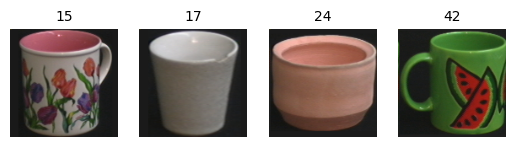

In [6]:
import matplotlib.pyplot as plt

# Display one image per selected object
f, axarr = plt.subplots(1, len(object_dict))
i = 0
for k in object_dict:
    axarr[i].axis('off')
    axarr[i].imshow(object_dict[k][0])
    axarr[i].set_title(k, fontsize=10)
    i += 1
plt.show()

## 2. Prepare Akida model for learning

.. Note:: Edge learning is only supported for Akida 1.0 models for now.



In [7]:
from akida_models import akidanet_edge_imagenet_pretrained
from cnn2snn import convert, set_akida_version, AkidaVersion

# Load a pre-trained model
with set_akida_version(AkidaVersion.v1):
    model_keras = akidanet_edge_imagenet_pretrained()

# Convert it to Akida
model_ak = convert(model_keras)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

/usr/local/lib/python3.10/dist-packages/akida_models/model_io.py:116: UserWarning: Model akidanet_imagenet_224_alpha_50_edge_iq8_wq4_aq4.h5 has been trained with akida_models 1.1.10 which is the last version supporting 1.0 models training
  warnings.warn(f'Model {model_name_v1} has been trained with akida_models 1.1.10 which is '


15990464/15990464 [==============================] - 3s 0us/step


In [8]:
from akida import AkidaUnsupervised

# Replace the last layer by a classification layer
num_classes = len(object_dict)
num_neurons_per_class = 1
num_weights = 350
model_ak.pop_layer()
layer_fc = FullyConnected(name='akida_edge_layer',
                          units=num_classes * num_neurons_per_class,
                          activation=False)
model_ak.add(layer_fc)
model_ak.compile(optimizer=AkidaUnsupervised(num_weights=num_weights,
                                             num_classes=num_classes,
                                             learning_competition=0.1))
model_ak.summary()

                 Model Summary                  
________________________________________________
Input shape    Output shape  Sequences  Layers
[224, 224, 3]  [1, 1, 4]     1          16    
________________________________________________

________________________________________________________________
Layer (type)                 Output shape    Kernel shape     

============= SW/conv_0-akida_edge_layer (Software) ============

conv_0 (InputConv.)          [112, 112, 16]  (3, 3, 3, 16)    
________________________________________________________________
conv_1 (Conv.)               [112, 112, 32]  (3, 3, 16, 32)   
________________________________________________________________
conv_2 (Conv.)               [56, 56, 64]    (3, 3, 32, 64)   
________________________________________________________________
conv_3 (Conv.)               [56, 56, 64]    (3, 3, 64, 64)   
________________________________________________________________
separable_4 (Sep.Conv.)      [28, 28, 128]   (3, 3,

## 3. Edge learning with Akida



In [9]:
import numpy as np

from tensorflow.image import resize_with_crop_or_pad
from time import time

# Learn objects in num_shots shot(s)
num_shots = 1
for i in range(len(object_ids)):
    start = time()
    train_images = object_dict[object_ids[i]][:num_shots]
    for image in train_images:
        padded_image = resize_with_crop_or_pad(image, 224, 224)
        model_ak.fit(np.expand_dims(padded_image, axis=0), i)
    end = time()
    print(f'Learned object {object_ids[i]} (class {i}) with \
            {len(train_images)} sample(s) in {end-start:.2f}s')

Learned object 15 (class 0) with             1 sample(s) in 0.17s
Learned object 17 (class 1) with             1 sample(s) in 0.12s
Learned object 24 (class 2) with             1 sample(s) in 0.12s
Learned object 42 (class 3) with             1 sample(s) in 0.12s


In [10]:
import statistics as stat

# Check accuracy against remaining samples
accuracy = []
for i in range(len(object_ids)):
    test_images = object_dict[object_ids[i]][num_shots:]
    predictions = np.zeros(len(test_images))
    for j in range(len(test_images)):
        padded_image = resize_with_crop_or_pad(test_images[j], 224, 224)
        predictions[j] = model_ak.predict_classes(np.expand_dims(padded_image,
                                                                 axis=0),
                                                  num_classes=num_classes)
    accuracy.append(100 * np.sum(predictions == i) / len(test_images))
    print(f'Accuracy testing object {object_ids[i]} (class {i}) with \
            {len(test_images)} sample(s): {accuracy[i]:.2f}%')

mean_accuracy = stat.mean(accuracy)
print(f'Mean accuracy: {mean_accuracy:.2f}%')

# For non-regression purposes
assert mean_accuracy > 94

Accuracy testing object 15 (class 0) with             71 sample(s): 100.00%
Accuracy testing object 17 (class 1) with             71 sample(s): 100.00%
Accuracy testing object 24 (class 2) with             71 sample(s): 100.00%
Accuracy testing object 42 (class 3) with             71 sample(s): 88.73%
Mean accuracy: 97.18%
